In [95]:
import requests
import time
import pandas as pd
import re
import os
from bs4 import BeautifulSoup

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

from IPython.display import display, HTML

In [3]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%%R

#install.packages("ggbeeswarm")
library(ggbeeswarm)

Loading required package: ggplot2


In [89]:
%%R

#install.packages("ggimage")
library(ggimage)

--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 2) [https]
16: China (Beijing 3) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Jinan) [https]
20: China (Lanzhou) [https]
21: China (Nanjing) [https]
22: China (Shanghai 2) [https]
23: China (Shenzhen) [https]
24: China (Wuhan) [https]
25: Colombia (Cali) [https]
26: Costa Rica [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: France (Lyon 1) [https]
33: France (Lyon 2) [https]
34: France (Paris 1) [h

Selection:  66



The downloaded binary packages are in
	/var/folders/29/tm85f6r96dl6jl70q7g6h2rr0000gn/T//RtmpxHBTWl/downloaded_packages


also installing the dependencies ‘yulab.utils’, ‘gridGraphics’, ‘ggfun’, ‘ggplotify’, ‘magick’

trying URL 'https://repo.miserver.it.umich.edu/cran/bin/macosx/big-sur-x86_64/contrib/4.4/yulab.utils_0.2.0.tgz'
Content type 'application/octet-stream' length 118833 bytes (116 KB)
downloaded 116 KB

trying URL 'https://repo.miserver.it.umich.edu/cran/bin/macosx/big-sur-x86_64/contrib/4.4/gridGraphics_0.5-1.tgz'
Content type 'application/octet-stream' length 248025 bytes (242 KB)
downloaded 242 KB

trying URL 'https://repo.miserver.it.umich.edu/cran/bin/macosx/big-sur-x86_64/contrib/4.4/ggfun_0.1.8.tgz'
Content type 'application/octet-stream' length 222485 bytes (217 KB)
downloaded 217 KB

trying URL 'https://repo.miserver.it.umich.edu/cran/bin/macosx/big-sur-x86_64/contrib/4.4/ggplotify_0.1.2.tgz'
Content type 'application/octet-stream' length 139379 bytes (136 KB)
downloaded 136 KB

trying URL 'https://repo.miserver.it.umich.edu/cran/bin/macosx/big-sur-x86_64/contrib/4.4/magick_2.8.5.tgz'

In [90]:
%%R 

library(tidyverse)
library(ggrepel)
library(readxl)

### ⚠️ The next three cells scrape Box Office Mojo and save the result to Excel. <br> <br> You can just run the fourth cell that reads in "valentines_movies.xlsx".

In [18]:
valentines_movies = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"
}

# Loop through each year from 2015 to 2025
for year in range(2015, 2026):
    url = f'https://www.boxofficemojo.com/month/february/{year}/?grossesOption=totalGrosses'
    raw_html = requests.get(url, headers=headers)
    soup_doc = BeautifulSoup(raw_html.content, "html.parser")
    
    # Find all movie rows (skip the first row because it's a header)
    movies = soup_doc.find_all('tr')[1:]

    # Loop through all the movie rows
    for movie in movies:
        try:
            title = movie.find_all('a')[0].text  # Movie Title
            release_date = movie.find_all('td')[10].text  # Release date
            day = int(release_date.split()[1])  # Extract day part
    
            # Filter movies released between Feb 1 and Feb 14
            if 1 <= day <= 14:
                link = "https://www.boxofficemojo.com" + movie.find_all('a')[0]['href']
                
                #time.sleep(2)  # Wait 2 seconds between requests
                
                subpage_html = requests.get(link, headers=headers)
                subpage_doc = BeautifulSoup(subpage_html.content, "html.parser")

                # divs containing genre
                genre_divs = subpage_doc.find_all('div', class_='a-section a-spacing-none')
                clean_genre = "Unknown"  # Default if genre is not found
                
                # dynamically looking for genre info
                for div in genre_divs:
                    spans = div.find_all('span')
                    if spans and "Genres" in spans[0].text:
                        clean_genre = ' '.join(spans[1].text.split())
                        break  # Stop looping once found
                        
                gross = subpage_doc.find_all(class_='money')[0].text
                
                logline = subpage_doc.find_all('p')[0].text
                
                valentines_movies.append([title, release_date, year, clean_genre, gross, logline])
            
        except (IndexError, AttributeError):
            # Skip rows that don't have expected data
            continue

In [19]:
# to dataframe
df = pd.DataFrame(valentines_movies, columns=["Title", "Release Date", "Year", "Genre", "Gross", "Logline"])
df

,Title,Release Date,Year,Genre,Gross,Logline
0,Fifty Shades of Grey,Feb 13,2015,Drama Romance Thriller,"$166,167,230",Literature student Anastasia Steele's life cha...
1,The SpongeBob Movie: Sponge Out of Water,Feb 6,2015,Adventure Animation Comedy Family Fantasy,"$162,994,032",When a diabolical pirate above the sea steals ...
2,Kingsman: The Secret Service,Feb 13,2015,Action Adventure Comedy Thriller,"$128,261,724",A spy organisation recruits a promising street...
3,Jupiter Ascending,Feb 6,2015,Action Adventure Sci-Fi,"$47,387,723",A young woman discovers her destiny as an heir...
4,Seventh Son,Feb 6,2015,Action Adventure Fantasy,"$17,223,265","When Mother Malkin, the queen of evil witches,..."
...,...,...,...,...,...,...
251,A Woman Is a Woman,Feb 7,2025,Comedy Drama Romance,"$58,771",A stripper who's desperate to become a mother ...
252,The Annihilation of Fish,Feb 14,2025,Romance,"$36,774","After years of living alone, an eccentric blac..."
253,I Love You Forever,Feb 7,2025,Comedy Drama,"$12,989",A subversive romantic comedy gone wrong that f...
254,When I'm Ready,Feb 7,2025,Romance,"$11,372",It's the end of the world. Seeking meaning and...


In [20]:
# df.to_excel('valentines_movies.xlsx', index=False)

## Start from here 🔽

In [ ]:
# df = pd.read_excel('valentines_movies.xlsx')

## Hand-curated (anti)romance movies ❤️🖤

#### After scraping all the movies released in the U.S. betweeen February 1 and 14 from 2015 to 2025, I went into the spreadsheet to hand-curate movies that are actually romance-related and American-made (in English, first released in the U.S.). I also got rid of re-releases.

#### `love_movies.xlsx` is my final list of 39 movies. I added a new column called 'Romance'. If a movie promotes a traditional sense of love and relationship, it's marked as 'pro'. Otherwise, it's marked as 'anti'.

In [98]:
select_df = pd.read_excel('love_movies.xlsx')

In [126]:
%%R -i select_df -o romance_plot -w 10 -h 5 --units in --res 100

# Convert Romance column to a factor for better categorization
select_df$Romance <- factor(select_df$Romance, levels = c("pro", "anti"))

# Create the beeswarm plot
romance_plot <- ggplot(select_df, aes(x = as.factor(Year), y = runif(nrow(select_df), -1, 1), color = Romance, size = Romance)) +
      geom_quasirandom(width = 0.4, alpha = 0.7) +  # Beeswarm effect with jitter
      scale_color_manual(values = c("pro" = "red", "anti" = "black")) +
      scale_size_manual(values = c("pro" = 3, "anti" = 7)) +
      guides(color = "none", size = "none") +  # Remove the legends
      theme_minimal() +
      theme(
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor.y = element_blank()
      ) +
      labs(x = "Year", color = "Romance Category",
           title = "Disillusioned Singles Take Over Hollywood",
           subtitle = "The Number of Romance and Anti-Romance Movies from 2015 to 2025 during Valentine's Season")

romance_plot

# Save the plot as an SVG file
# ggsave("romance_plot.svg", plot = romance_plot, width = 10, height = 5, units = "in", dpi = 300)

In [43]:
# Format "Gross" column with a dollar sign and thousand separator
# select_df['Gross'] = select_df['Gross'].apply(lambda x: f'${x:,}')

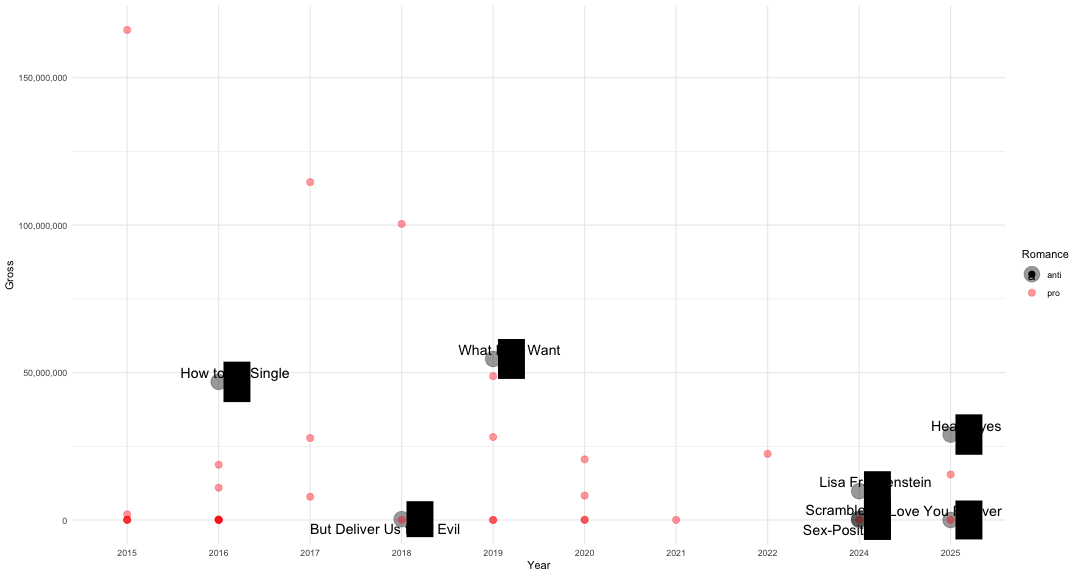

In [121]:
%%R -i select_df -w 15 -h 8 --units in

select_df$Year <- factor(select_df$Year)

anti_romance_with_poster <- subset(select_df, Romance == "anti" & Poster != "")

ggplot(select_df, aes(x=Year, y=Gross, color=Romance, size=Romance, label=Title)) +
       geom_point(alpha=.4) +
       scale_y_continuous(labels = scales::comma) +
       scale_color_manual(values = c("pro" = "red", "anti" = "black")) +
       scale_size_manual(values = c("pro" = 3, "anti" = 7)) +
       theme_minimal() +
       geom_text_repel(data = subset(select_df, Romance == "anti"), 
                       aes(label = Title),
                       size = 5, max.overlaps = 10) +
       # Add film posters only for anti-romance movies with valid local file paths
       geom_image(data = anti_romance_with_poster, 
               aes(x = as.numeric(Year) + 0.2, image = Poster), 
               size = 0.05)


In [125]:
%%R -i select_df -w 15 -h 8 --units in

select_df$Year <- factor(select_df$Year)

money_plot <- ggplot(select_df, aes(x=Year, y=Gross, color=Romance, size=Romance, label=Title)) +
       geom_point(alpha=.4) +
       scale_y_continuous(labels = scales::comma) +
       scale_color_manual(values = c("pro" = "red", "anti" = "black")) +
       scale_size_manual(values = c("pro" = 3, "anti" = 7)) +
       theme_minimal() +
       geom_text_repel(data = subset(select_df, Romance == "anti"), 
                       aes(label = Title),
                       size = 5, max.overlaps = 10)

ggsave("money_plot.svg", plot=money_plot, width = 15, height = 8)